In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from anomaly.constants import GALAXY_LINES

In [2]:
# GALAXY_LINES

In [3]:
# constants
lines = {
    "NII_1":6548.041,
    "H-alpha": 6562.787,
    "NII_2": 6583.461,
}

In [4]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
metric = "mse_noRel100"
data_directory = (
    f"{work_directory}/{bin_id}/"
    f"explanation/{model}/{metric}"
)

In [5]:
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz",
    index_col="specobjid"
)

wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")

# load the weights
explanation_weights = np.load(f"{data_directory}/weights_all_abs.npy")

In [6]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

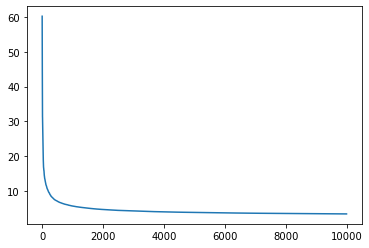

In [7]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies and weights array as well
anomalies = anomalies[::-1]

plt.plot(df_anomalies["score"].to_numpy())

## Clustering of weights for H $\alpha$ + [NII] doublet

In [8]:
# Define the regions of interest
radious = 20

mask_region_of_interest = (
    (wave > lines["NII_1"] - radious) &
    (wave < lines["NII_2"] + radious)
)

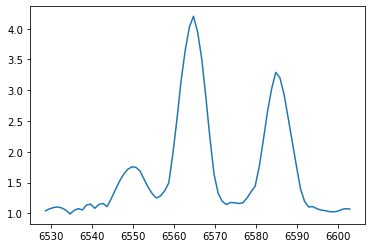

In [9]:
plt.plot(
    wave[mask_region_of_interest],
    anomalies[100][mask_region_of_interest]
)

In [10]:
# create array to store the weights of the h alpha NII region 
region_weights = explanation_weights[:, mask_region_of_interest]
region_weights.shape, region_weights.min(), region_weights.max()

((10000, 75), 0.0, 1.0)

n: 2, inertia: 37580.15016371273
n: 3, inertia: 22030.37574860258
n: 4, inertia: 15263.939996979063
n: 5, inertia: 12409.869758822924
n: 6, inertia: 10123.378312164785
n: 7, inertia: 8821.257658998453
n: 8, inertia: 7917.1386513169045
n: 9, inertia: 7089.102815766088
n: 10, inertia: 6426.813226137337
n: 11, inertia: 5877.9120543795125
n: 12, inertia: 5505.020602918466
n: 13, inertia: 5177.894535813787
n: 14, inertia: 4810.917755958038
n: 15, inertia: 4490.832618470634
n: 16, inertia: 4264.703351821033
n: 17, inertia: 4052.9480928397784
n: 18, inertia: 3878.4603587446836
n: 19, inertia: 3710.397911574816


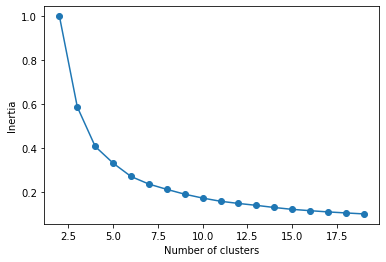

In [11]:
# Create a list to store the evaluation metric values
inertias = []
n_clusters = range(2, 20)

# Fit the k-means model with a range of values for the number of clusters

for n in n_clusters:

    kmeans = KMeans(n_clusters=n, random_state=0)

    kmeans.fit(region_weights)
    inertias.append(kmeans.inertia_)

    print(f"n: {n}, inertia: {kmeans.inertia_}")

# normalize the inertias
inertias = np.array(inertias) / np.max(inertias)

# Plot the evaluation metric values against the number of clusters
plt.plot(n_clusters, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [12]:
# Use a k-means clustering for the balmer region

n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, random_state=0)

cluster_labels = kmeans.fit_predict(region_weights)

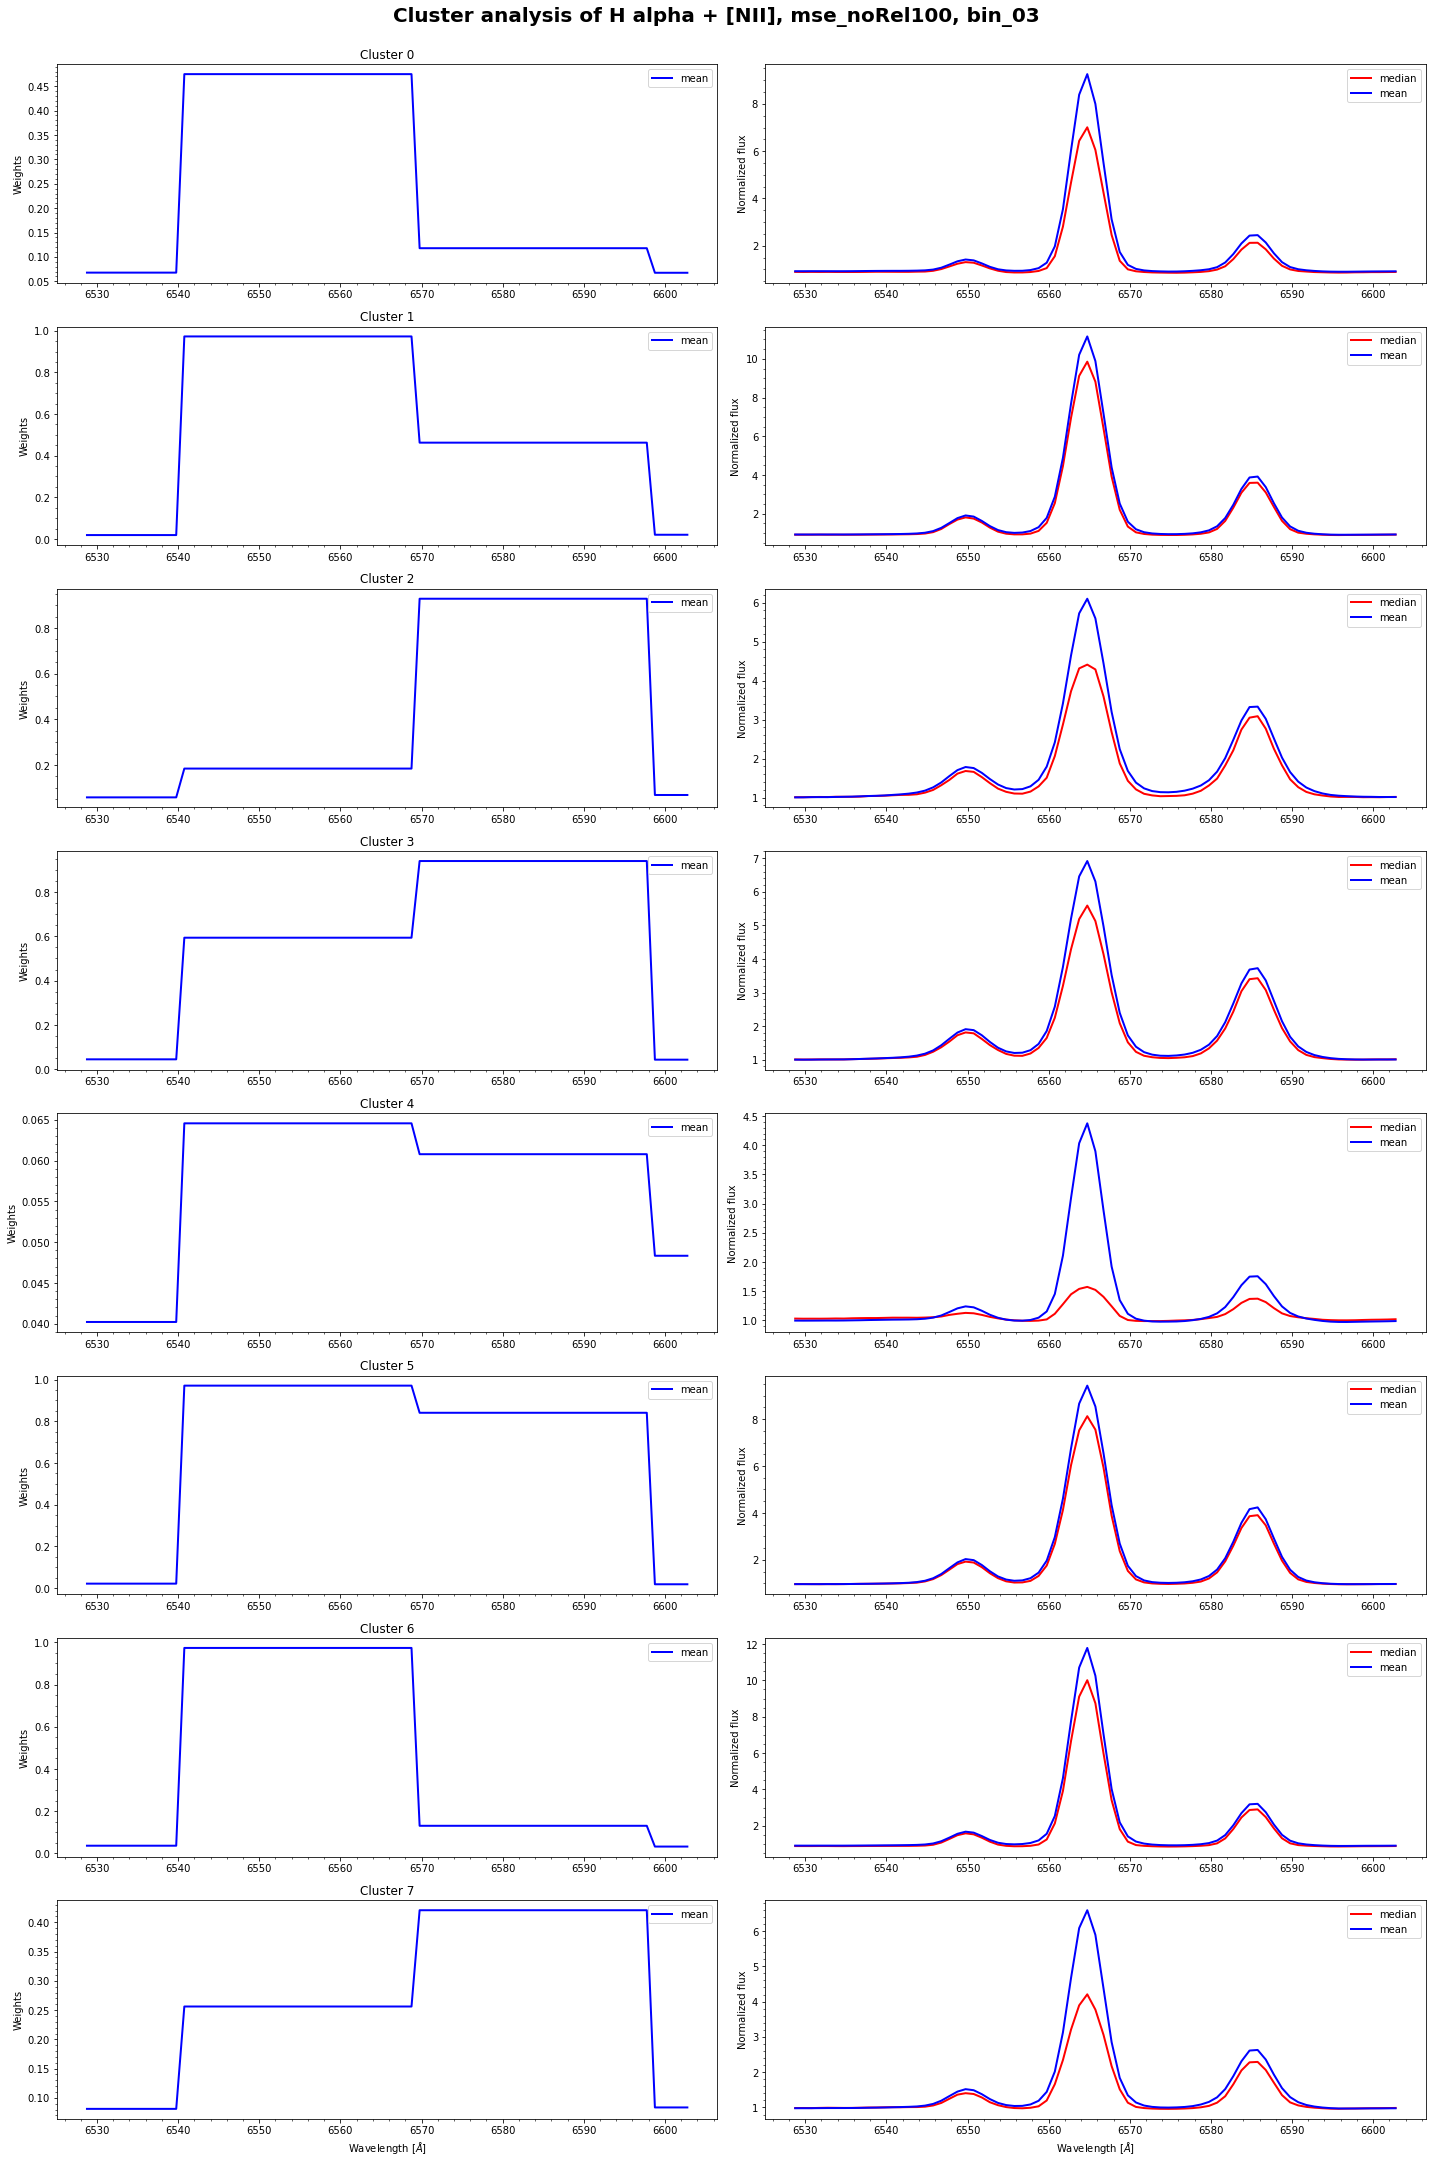

In [13]:
# Create a figure with a grid of subplots
n_subplots = 2
fig, axs = plt.subplots(
    kmeans.n_clusters, n_subplots,
    tight_layout=True,
    sharex=False, sharey=False,
    figsize=(20, 30)
)

# minor ticks on
for ax in axs.flat:
    ax.minorticks_on()

# Add a title to the figure
fig.suptitle(
    f"Cluster analysis of H alpha + [NII], {metric}, {bin_id}",
    fontsize=20,
    fontweight="bold",
    y=1.
)

# Loop over the clusters
for cluster_n in range(kmeans.n_clusters):

    # Select the spectra in the cluster
    cluster_anomalies = anomalies[cluster_labels == cluster_n]
    # cluster_anomalies[:, ~balmer_mask] = np.nan

    cluster_weights = explanation_weights[cluster_labels == cluster_n]
    # cluster_weights[:, ~balmer_mask] = np.nan

    # Compute summary statistics for the explanations in the cluster
    cluster_median_weights = np.nanmedian(cluster_weights, axis=0)
    cluster_mean_weights = np.nanmean(cluster_weights, axis=0)
    cluster_std_weights = np.nanstd(cluster_weights, axis=0)

    # Compute summary statistics for the anomalies in the cluster

    cluster_median_anomalies = np.nanmedian(cluster_anomalies, axis=0)
    cluster_mean_anomalies = np.nanmean(cluster_anomalies, axis=0)
    cluster_std_anomalies = np.nanstd(cluster_anomalies, axis=0)

    # plot weights even columns and balmer lines in odd columns

    # axs[cluster_n, 0].plot(
    #     wave[h_delta_mask], cluster_median_weights[h_delta_mask], color="red", label="median", linewidth=2,
    # )
    axs[cluster_n, 0].plot(
        wave[mask_region_of_interest],
        cluster_mean_weights[mask_region_of_interest],
        color="blue", label="mean", linewidth=2,
    )

    axs[cluster_n, 1].plot(
        wave[mask_region_of_interest],
        cluster_median_anomalies[mask_region_of_interest],
        color="red", label="median", linewidth=2,
    )

    axs[cluster_n, 1].plot(
        wave[mask_region_of_interest],
        cluster_mean_anomalies[mask_region_of_interest],
        color="blue", label="mean", linewidth=2,
    )


    axs[cluster_n, 0].set_title(f"Cluster {cluster_n}")
    axs[cluster_n, 0].set_ylabel("Weights")
    axs[cluster_n, 1].set_ylabel("Normalized flux")


    axs[cluster_n, 0].legend()
    axs[cluster_n, 1].legend()

axs[-1, 0].set_xlabel("Wavelength [$\AA$]")
axs[-1, 1].set_xlabel("Wavelength [$\AA$]")
#save the figure in data_directory in pdf format

fig.savefig(
    f"{data_directory}/halpha_NII_clustering_{n_clusters}.pdf"
)
